# Advanced Lane Finding

The goals / steps of this project are the following:

1) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

2) Apply the distortion correction to the raw image.

3) Use color transforms, gradients, etc., to create a thresholded binary image.

4) Apply a perspective transform to rectify binary image ("birds-eye view").

5) Detect lane pixels and fit to find lane boundary.

6) Determine curvature of the lane and vehicle position with respect to center.

7) Warp the detected lane boundaries back onto the original image.

8 )Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import glob
import numpy as np
import cv2
from Sobel import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import scipy.misc
from PIL import Image
from PIL import ImageEnhance
from FindLanes import Lane
from Smooth import SmoothLane

%matplotlib inline

lane = SmoothLane(margin=100, minpix=75)

In [2]:
def cleanup_histogram(hist, thresh=100):
    for i in range(np.shape(hist)[0]):
        if hist[i] < thresh:
            hist[i] = 0
    return hist


# Most of the images are based on 9x6 squares. SOme of them are different but
# %80 of them are 9x6 so I used this values to undistort images
def calibrate_camera():
    nx = 9
    ny = 6
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    imgpoints = []
    objpoints = []
    
    files = glob.glob('./camera_cal/*.jpg')
    for i, file in enumerate(files):
        img = mpimg.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def undistort(img, mtx, dists):
    return cv2.undistort(img, mtx, dists, None, None)

def rgb_2_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def mask_image(img, thresh=(0, 255)):
    mask = np.zeros_like(img)
    mask[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return mask

def save_img(img, path):
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, bgr_img)
    
def region_of_interest(current_mask, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(current_mask)
    ignore_mask_color = 1
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    return mask & current_mask

def plot_images(img1, img2, title=None, subtitle1=None, subtitle2=None):
    f = plt.figure()
    if title is not None:
        plt.suptitle(title)
    
    f.add_subplot(1, 2, 1)

    if img1.shape[-1] != 3:
        plt.imshow(img1, cmap='gray')
    else:
        plt.imshow(img1)
        
    if subtitle1 is not None:
        plt.title(subtitle1, fontsize=10)
    
    f.add_subplot(1, 2, 2)
    if img2.shape[-1] != 3:
        plt.imshow(img2, cmap='gray')
    else:
        plt.imshow(img2,)
    if subtitle2 is not None:
        plt.title(subtitle2, fontsize=10)
    

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
mtx, dists = calibrate_camera()

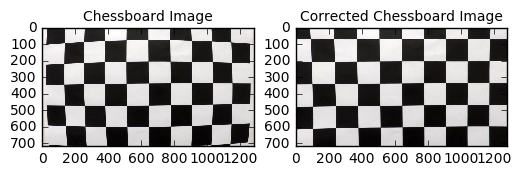

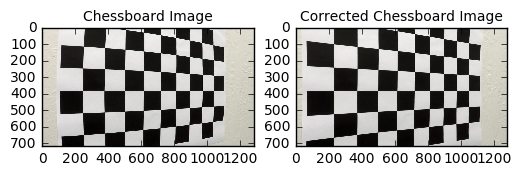

In [4]:
chess_table = mpimg.imread('camera_cal/calibration1.jpg')
corrected_chess = undistort(chess_table, mtx, dists)
plot_images(chess_table, corrected_chess, 
            subtitle1='Chessboard Image', subtitle2='Corrected Chessboard Image')

chess_table = mpimg.imread('camera_cal/calibration5.jpg')
corrected_chess = undistort(chess_table, mtx, dists)
plot_images(chess_table, corrected_chess, 
            subtitle1='Chessboard Image', subtitle2='Corrected Chessboard Image')

Apply the distortion correction to the raw image along side with transformation, color thresholding etc. functions

In [28]:
def remove_noise(img):
    img = cv2.erode(img, np.ones((5, 5)))
    img = cv2.dilate(img, np.ones((7, 7)))
    
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
    mask = cv2.morphologyEx(img, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    mask = mask / 255
    
    return img * mask
    
def color_threshold(img, mask_thresh=None):
    if None:
        return img
    
    hue = img[:,:,0]
    sat = img[:,:,1]
    val = img[:,:,2]
    hue_thresh = mask_thresh[0]
    sat_thresh = mask_thresh[1]
    val_thresh = mask_thresh[2]
    
    color_mask = np.zeros_like(img[:,:,1])
    color_mask[(hue >= hue_thresh[0]) & (hue <= hue_thresh[1]) & 
        (sat >= sat_thresh[0]) & (sat <= sat_thresh[1]) & 
        (val >= val_thresh[0]) & (val <= val_thresh[1])] = 1
    
    return color_mask
 
def transform_image(img):
#     src = np.array([[205, 710], [1106, 710], [752, 480], [545, 480]], np.float32)
#     dst = np.array([[205, 710], [1106, 710], [1106, 0], [225, 0]], np.float32)
    src = np.array([[205, 720], [1120, 720], [754, 480], [540, 480]], np.float32)
    dst = np.array([[205, 720], [1120, 720], [1120, 0], [205, 0]], np.float32)
#     src = np.array([[585, 460], [203, 720], [1127, 720], [695, 460]], np.float32)
#     dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]], np.float32)
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    perspected = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return perspected, M, Minv



def pipeline(img, plot=False):
    img_size = (1280, 720)
    img = undistort(img, mtx, dists)
    img_copy = img.copy()
    
    perspected, M, reverse_M = transform_image(img)
    hsv = cv2.cvtColor(perspected, cv2.COLOR_RGB2HSV)
#     gray = cv2.cvtColor(perspected, cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    hsv[:,:,1] = clahe.apply(hsv[:,:,1])
    yellow_mask = color_threshold(hsv, mask_thresh=[[18,31], [60,255], [90,255]])
    white_mask = color_threshold(hsv, mask_thresh=[[0,57], [90,255], [180,255]])
#     sobel_x = abs_sobel_thresh(hsv[:,:,1], orient='x', sobel_kernel=3, thresh=(40, 100))
#     mag = mag_thresh(perspected, sobel_kernel=5, mag_thresh=(60, 255))
    
    sobel_x = abs_sobel_thresh(perspected, orient='x', sobel_kernel=3, thresh=(15, 100))
    mag = mag_thresh(perspected, sobel_kernel=3, mag_thresh=(30, 200))
    
    img = yellow_mask | white_mask | mag | sobel_x
    vertices = [np.array([ [150, 720], [1200,720],[1200,0], [150,0] ], np.int32)]
    img = region_of_interest(img, vertices)
    img = remove_noise(img)
    global lane
    if lane is None:
        print("Lane is None")
        lane = SmoothLane(margin=100, minpix=50)
    lane.search(img)
    img = lane.translate_to_real_world_image(img_copy, reverse_M)
    if plot:
        plt.figure()
        lane.plot()
    
    
    return img
    
    
    

Applies lane finding techniques on test images and save results in output_images folder

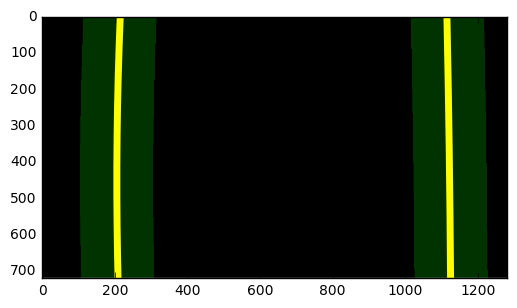

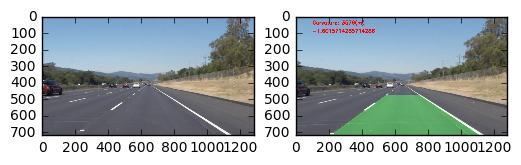

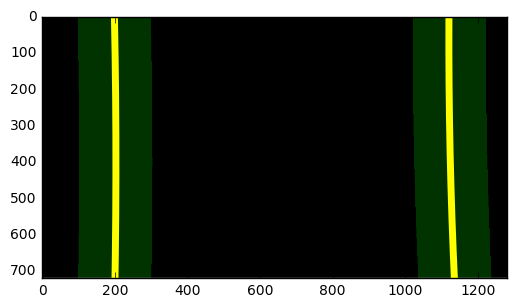

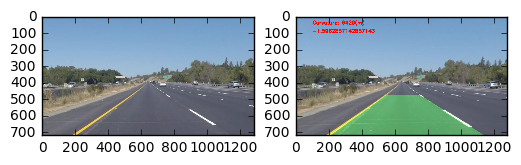

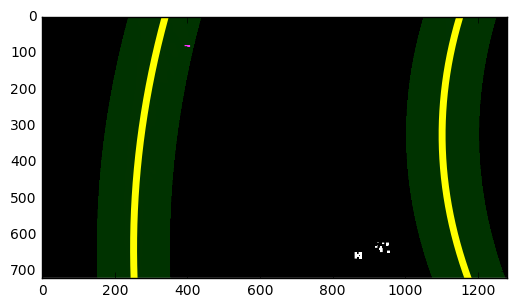

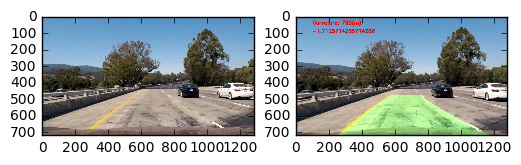

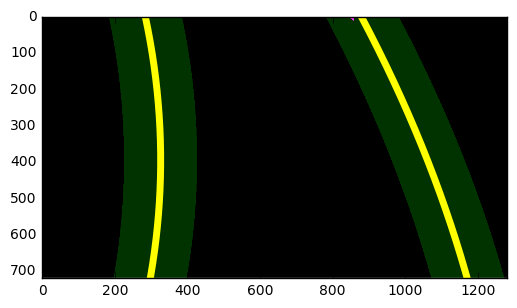

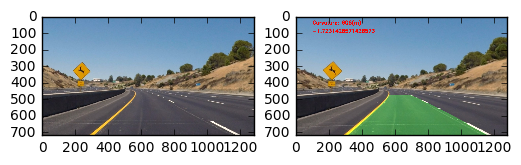

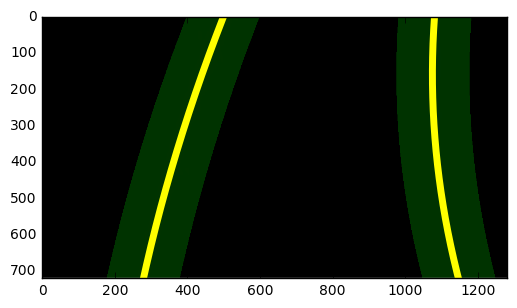

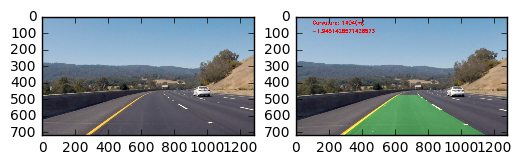

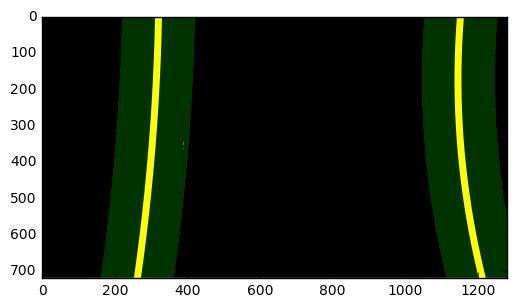

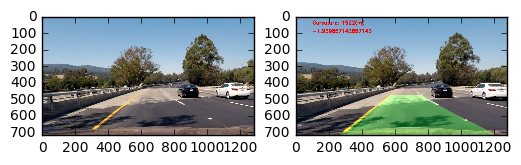

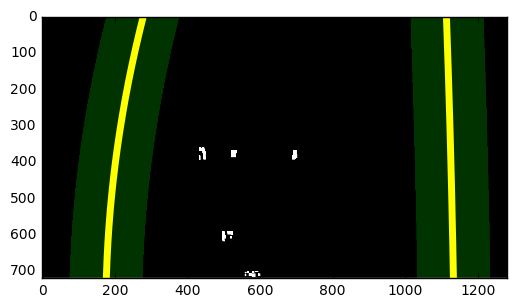

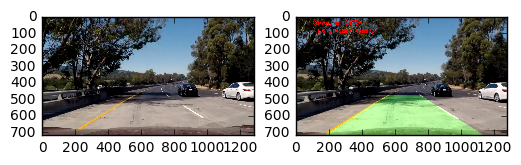

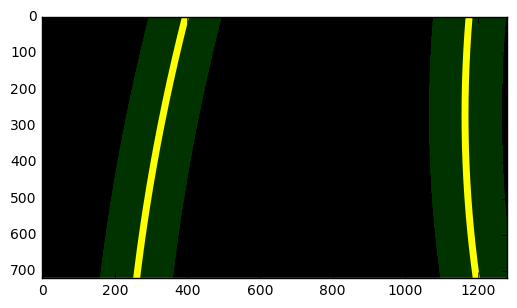

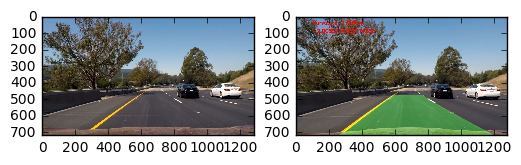

In [29]:
files = glob.glob('./test_images/*.jpg')
for i, file in enumerate(files):
#     if i == 0:
#         print(file)
#         img2 = Image.open(file)
#         img2 = undistort(np.array(img2), mtx, dists)
#         save_img(img2, "./output_images/undistorted_img.jpg")
#         perspected, M, reverse_M = transform_image(img2)
#         save_img(perspected, "./output_images/perspected_img.jpg")
        
    img = Image.open(file)#mpimg.imread(file)
    img_size = (1280, 720)
    resized_img = np.array(img.resize(img_size, Image.ANTIALIAS))
    
    pipelined_img = pipeline(resized_img, plot=True)
    plot_images(resized_img, pipelined_img)
    global lane
    lane = SmoothLane(margin=100, minpix=50)
    
    save_img(pipelined_img, './output_images/' + str(i) + '.jpg')

Apply method on Project Video

In [7]:
global lane
lane = SmoothLane(margin=100, minpix=50)
white_output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
   
clip_res = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip_res.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [16:01<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 22min 52s, sys: 3min 9s, total: 26min 1s
Wall time: 16min 2s


In [8]:
%%HTML
<video width="640" height="480" controls>
  <source src="result.mp4" type="video/mp4">
</video>

Apply method on Challenge Video

In [9]:
global lane
lane = SmoothLane(margin=100, minpix=50)
white_output = 'result_challenge.mp4'
clip = VideoFileClip("challenge_video.mp4")
   
clip_res = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip_res.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result_challenge.mp4
[MoviePy] Writing video result_challenge.mp4


100%|██████████| 485/485 [05:14<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_challenge.mp4 

CPU times: user 8min 21s, sys: 1min 5s, total: 9min 27s
Wall time: 5min 15s


In [10]:
%%HTML
<video width="640" height="480" controls>
  <source src="result_challenge.mp4" type="video/mp4">
</video>

Apply method on harder challenge video, however, in this video my method fail to recognize lanes

In [11]:
global lane
lane = SmoothLane(margin=100, minpix=50)
white_output = 'result_harder_challenge.mp4'
clip = VideoFileClip("harder_challenge_video.mp4")
   
clip_res = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip_res.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result_harder_challenge.mp4
[MoviePy] Writing video result_harder_challenge.mp4


100%|█████████▉| 1199/1200 [14:25<00:00,  1.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_harder_challenge.mp4 

CPU times: user 22min 6s, sys: 2min 58s, total: 25min 5s
Wall time: 14min 26s


In [12]:
%%HTML
<video width="640" height="480" controls>
  <source src="result_harder_challenge.mp4" type="video/mp4">
</video>